In [8]:
CSV_FILE_BW = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_10_22_14_12_15/ops_perf_results_2025_10_22_14_12_15.csv"

CSV_MOREH = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_10_21_14_55_32/ops_perf_results_2025_10_21_14_55_32.csv"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact


In [4]:
df = pd.read_csv(CSV_FILE_BW)

# Rename the columns for clarity
df = df.rename(columns={
    'OP CODE': 'Operation',
    'HOST DURATION [ns]': 'Host Time',
    'OP TO OP LATENCY [ns]': 'Time Between Ops',
    'DEVICE FW DURATION [ns]': 'Device Time'
})

In [5]:
df

,Operation,OP TYPE,GLOBAL CALL COUNT,DEVICE ID,ATTRIBUTES,MATH FIDELITY,CORE COUNT,PARALLELIZATION STRATEGY,HOST START TS,HOST END TS,...,IDLE ETH DM 1 MAX KERNEL SIZE [B],PM IDEAL [ns],PM COMPUTE [ns],PM BANDWIDTH [ns],PM REQ I BW,PM REQ O BW,PM FPU UTIL (%),NOC UTIL (%),DRAM BW UTIL (%),NPE CONG IMPACT (%)
0,ProfilerNoopOperation,tt_dnn_device,1024,0,{'identifier': 'start_tensor_creation_xxlarge_...,NaN,1,NaN,7176376991,7176593649,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
1,ProfilerNoopOperation,tt_dnn_device,2048,0,{'identifier': 'start_tensor_creation_xxlarge_...,NaN,1,NaN,7176694849,7176700499,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
2,ProfilerNoopOperation,tt_dnn_device,3072,0,{'identifier': 'start_tensor_creation_xxlarge_...,NaN,1,NaN,7176733808,7176735518,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
3,ProfilerNoopOperation,tt_dnn_device,4096,0,{'identifier': 'start_tensor_creation_xxlarge_...,NaN,1,NaN,7176759418,7176761118,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
4,ProfilerNoopOperation,tt_dnn_device,5120,0,{'identifier': 'start_tensor_creation_xxlarge_...,NaN,1,NaN,7176791128,7176792768,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,ProfilerNoopOperation,tt_dnn_device,686080,0,{'identifier': 'profiling_complete_medium_4x51...,NaN,1,NaN,23929404046,23929406196,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
670,ProfilerNoopOperation,tt_dnn_device,687104,0,{'identifier': 'profiling_complete_medium_4x51...,NaN,1,NaN,23929427896,23929429366,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
671,ProfilerNoopOperation,tt_dnn_device,688128,0,{'identifier': 'profiling_complete_medium_4x51...,NaN,1,NaN,23929452876,23929454566,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN
672,ProfilerNoopOperation,tt_dnn_device,689152,0,{'identifier': 'profiler_shutdown'},NaN,1,NaN,23930423019,23930531318,...,0,1,1,1,[],[],0.03,NaN,NaN,NaN


In [71]:
df.loc[:50]

,Operation,OP TYPE,GLOBAL CALL COUNT,DEVICE ID,ATTRIBUTES,MATH FIDELITY,CORE COUNT,PARALLELIZATION STRATEGY,HOST START TS,HOST END TS,...,IDLE ETH DM 1 MAX KERNEL SIZE [B],PM IDEAL [ns],PM COMPUTE [ns],PM BANDWIDTH [ns],PM REQ I BW,PM REQ O BW,PM FPU UTIL (%),NOC UTIL (%),DRAM BW UTIL (%),NPE CONG IMPACT (%)
0,RandDeviceOperation,tt_dnn_device,1024,0,{'device': 'MeshDevice **'; 'dtype': 'DataType...,HiFi4,64,NaN,5739713303,5740109370,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
1,TypecastDeviceOperation,tt_dnn_device,2048,0,{'bfp8_pack_precise': 'false'; 'fp32_dest_acc_...,HiFi4,64,NaN,6835821019,6836071557,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
2,RandDeviceOperation,tt_dnn_device,3072,0,{'device': 'MeshDevice **'; 'dtype': 'DataType...,HiFi4,64,NaN,6837570917,6837725075,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
3,TypecastDeviceOperation,tt_dnn_device,4096,0,{'bfp8_pack_precise': 'false'; 'fp32_dest_acc_...,HiFi4,64,NaN,6837846075,6837852795,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
4,MorehLayerNormOperation,tt_dnn_device,5120,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,10066642576,10066931214,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
5,MorehLayerNormBackwardInputGradOperation,tt_dnn_device,6144,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,12776769645,12776986053,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
6,MorehLayerNormBackwardGammaBetaGradOperation,tt_dnn_device,7168,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,32,NaN,14284481852,14284720490,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
7,ProfilerNoopOperation,tt_dnn_device,8192,0,{'identifier': 'updating grad vars started'},NaN,1,NaN,15171499421,15171668630,...,0,1,1,1,[],[],0.030,NaN,NaN,NaN
8,ProfilerNoopOperation,tt_dnn_device,9216,0,{'identifier': 'updating grad vars started'},NaN,1,NaN,15186795683,15186808003,...,0,1,1,1,[],[],0.030,NaN,NaN,NaN
9,ProfilerNoopOperation,tt_dnn_device,10240,0,{'identifier': 'updating grad vars completed'},NaN,1,NaN,15187475098,15187584377,...,0,1,1,1,[],[],0.030,NaN,NaN,NaN


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(GPT2S_WITH_FUSED_BACKWARD)

# Rename the columns for clarity
df = df.rename(columns={
    'OP CODE': 'Operation',
    'HOST DURATION [ns]': 'Host Time',
    'OP TO OP LATENCY [ns]': 'Time Between Ops',
    'DEVICE FW DURATION [ns]': 'Device Time'
})
# import pandas as pd

# def reduce_consecutive_pandas_min(indices):
        
#     df = pd.DataFrame({'idx': sorted(indices)})
    
#     # Create groups for consecutive numbers
#     df['group'] = (df['idx'].diff() != 1).cumsum()
    
#     # Get minimum of each group
#     result = df.groupby('group')['idx'].min().tolist()
#     return result

# def reduce_consecutive_pandas_max(indices):
        
#     df = pd.DataFrame({'idx': sorted(indices)})
    
#     # Create groups for consecutive numbers
#     df['group'] = (df['idx'].diff() != 1).cumsum()
    
#     # Get minimum of each group
#     result = df.groupby('group')['idx'].max().tolist()
#     return result


# mask = (df['Operation'] == 'ProfilerNoopOperation') & df['ATTRIBUTES'].str.contains('updating grad vars started', na=False)
# started_updating_grad_vars = reduce_consecutive_pandas_min(df.index[mask])
# mask = (df['Operation'] == 'ProfilerNoopOperation') & df['ATTRIBUTES'].str.contains('updating grad vars completed', na=False)
# completed_updating_grad_vars = reduce_consecutive_pandas_max(df.index[mask])
# for start, end in reversed(list(zip(started_updating_grad_vars, completed_updating_grad_vars))):
#     df = pd.concat([df.iloc[:start+1], df.iloc[end:]], ignore_index=True)

# Filter out rows before compilation finished
mask = (df['Operation'] == 'ProfilerNoopOperation') & df['ATTRIBUTES'].str.contains('compilation_finished', na=False)
matching_indices = df.index[mask]
assert not matching_indices.empty, "No 'compilation_finished' found in ProfilerNoopOperation attributes"
latest_compilation_flag = matching_indices[-1]
df = df.iloc[latest_compilation_flag + 1:]

# Find number of training steps
# mask = (df['Operation'] == 'ProfilerNoopOperation') & df['ATTRIBUTES'].str.contains('iteration_', na=False)
# matching_indices = df.index[mask]
# num_training_steps = 3 # for backward compatibility, will be removed before merge
# if not matching_indices.empty:
#     filtered_df = df[df.index.isin(matching_indices)]
#     num_training_steps = len(filtered_df['ATTRIBUTES'].unique())

df = df[df['Operation'] != 'ProfilerNoopOperation']

all_operations = df['Operation'].unique()



In [ ]:

GPT2_NANO_WITH_MOREH = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_10_22_15_18_58/ops_perf_results_2025_10_22_15_18_58.csv"
GPT2_NANO_WITH_FUSED_BACKWARD = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_10_22_15_31_19/ops_perf_results_2025_10_22_15_31_19.csv"



In [5]:
GPT2S_WITH_MOREH = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_10_23_09_09_57/ops_perf_results_2025_10_23_09_09_57.csv"
GPT2S_WITH_FUSED_BACKWARD = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_10_26_20_31_17/ops_perf_results_2025_10_26_20_31_17.csv"

In [74]:
mask = (df['Operation'] == 'BinaryNgDeviceOperation')
df.index[mask]

Index([ 76,  77,  78, 126, 127, 128, 176, 177, 178, 226, 227, 228, 276, 277,
       278, 326, 327, 328, 376, 377, 378, 426, 427, 428, 476, 477, 478, 526,
       527, 528],
      dtype='int64')

In [75]:
df = df[df['Operation'] != 'ProfilerNoopOperation']

all_operations = df['Operation'].unique()

In [11]:
df

,Operation,OP TYPE,GLOBAL CALL COUNT,DEVICE ID,ATTRIBUTES,MATH FIDELITY,CORE COUNT,PARALLELIZATION STRATEGY,HOST START TS,HOST END TS,...,IDLE ETH DM 1 MAX KERNEL SIZE [B],PM IDEAL [ns],PM COMPUTE [ns],PM BANDWIDTH [ns],PM REQ I BW,PM REQ O BW,PM FPU UTIL (%),NOC UTIL (%),DRAM BW UTIL (%),NPE CONG IMPACT (%)
66,LayerNormBackwardDeviceOperation,tt_dnn_device,68608,0,{'epsilon': '1e-05'},HiFi4,16,NaN,19265654745,19265657925,...,0,1,1,1,[],[],0.000,NaN,NaN,NaN
67,FastReduceNCDeviceOperation,tt_dnn_device,69632,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19265712295,19265716125,...,0,30281,1,30281,[277.02545166015625],[277.02545166015625],0.001,NaN,NaN,NaN
68,FastReduceNCDeviceOperation,tt_dnn_device,70656,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19265762245,19265768955,...,0,30281,1,30281,[277.02545166015625],[69.25636291503906],0.002,NaN,NaN,NaN
69,Reduce,tt_dnn_device,71680,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19265845774,19265848644,...,0,7570,1,7570,[277.03460693359375],[69.25865173339844],0.006,NaN,NaN,NaN
70,FastReduceNCDeviceOperation,tt_dnn_device,72704,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19265900164,19265903024,...,0,30281,1,30281,[277.02545166015625],[277.02545166015625],0.001,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,FastReduceNCDeviceOperation,tt_dnn_device,319488,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19531726143,19531728983,...,0,30281,1,30281,[277.02545166015625],[69.25636291503906],0.002,NaN,NaN,NaN
312,Reduce,tt_dnn_device,320512,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19531806683,19531809253,...,0,7570,1,7570,[277.03460693359375],[69.25865173339844],0.006,NaN,NaN,NaN
313,FastReduceNCDeviceOperation,tt_dnn_device,321536,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19531860822,19531863252,...,0,30281,1,30281,[277.02545166015625],[277.02545166015625],0.001,NaN,NaN,NaN
314,FastReduceNCDeviceOperation,tt_dnn_device,322560,0,{'compute_kernel_config': 'WormholeComputeKern...,HiFi4,64,NaN,19531891412,19531893252,...,0,30281,1,30281,[277.02545166015625],[69.25636291503906],0.002,NaN,NaN,NaN


In [77]:
forward_ops = df[df['Operation'].str.contains('forward', case=False, na=False)]
backward_ops = df[df['Operation'].str.contains('backward', case=False, na=False)]
pass_ops = df[df['Operation'].str.contains('pass', case=False, na=False)]

In [78]:
noop_ops = df[df['Operation'].str.contains('profiler_no_op', case=False, na=False)]

In [15]:
grouped = df.groupby('Operation').agg({
        'Host Time': "sum",
        'Time Between Ops': "sum",
        'Device Time': "sum"
    })
print(grouped)    

                                     Host Time  Time Between Ops  Device Time
Operation                                                                    
BinaryNgDeviceOperation                2305284          16238614    225875172
ConcatDeviceOperation                   174107             37570     23873124
CrossEntropyBackwardDeviceOperation      40660            503673      1945184
CrossEntropyForwardDeviceOperation       48829              5313      8356128
DropoutDeviceOperation                 1234290          14831263    146309146
EmbeddingBackward                        37259             63696     48591262
Embeddings                               48510            692442      1826524
FastReduceNCDeviceOperation            1435858            285537     58091757
FullLikeOperation                        58630            849563       157839
GeluBackwardDeviceOperation             237377             34337    195030616
LayerNormBackwardDeviceOperation        779936             70609

In [18]:
df.loc[:, ['Host Time', 'Device Time']].sum()

Host Time        19222479
Device Time    3011425035
dtype: int64

In [4]:
# GPT2S_WITH_MOREH
df.loc[:, ['Host Time', 'Device Time']].sum()

Host Time        46032644
Device Time    8530243930
dtype: int64

In [7]:
# GPT2S_WITH_FUSED_BACKWARD
df.loc[:, ['Host Time', 'Device Time']].sum()

Host Time        49054090
Device Time    8368088136
dtype: int64

In [8]:
(8368088136 + 49054090) / (8530243930 + 46032644)

0.9814448208815426

In [20]:
grouped = df.groupby('Operation').agg({
        'Host Time': "sum",
        'Time Between Ops': "sum",
        'Device Time': "sum"
    })
print(grouped)    

                                              Host Time  Time Between Ops  \
Operation                                                                   
BinaryNgDeviceOperation                         2400939          17660977   
ConcatDeviceOperation                            187109             30336   
CrossEntropyBackwardDeviceOperation               60080           2287407   
CrossEntropyForwardDeviceOperation                60429              5347   
DropoutDeviceOperation                          1503301          15244135   
EmbeddingBackward                                 58199            121571   
Embeddings                                        37300            606938   
FullLikeOperation                                 61750            856358   
GeluBackwardDeviceOperation                      291816             34090   
Matmul                                          3704344           1421012   
MorehAdamWDeviceOperation                       1914291           1196186   

In [21]:
df.loc[:, ['Host Time', 'Device Time']].sum()

Host Time        17785757
Device Time    3178753641
dtype: int64

In [22]:
(19222479 + 3011425035)/(17785757 + 3178753641)

0.9481026624906314

In [6]:
grouped = df.groupby('Operation').agg({
        'Host Time': "sum",
        'Time Between Ops': "sum",
        'Device Time': "sum"
    })
print(grouped)    

                                  Host Time  Time Between Ops  Device Time
Operation                                                                 
FastReduceNCDeviceOperation          129158             23845     17140791
LayerNormBackwardDeviceOperation      32610            596347     15024214
Reduce                                53330             11579       638708


In [10]:
grouped = df.groupby('Operation').agg({
        'Host Time': "sum",
        'Time Between Ops': "sum",
        'Device Time': "sum"
    })
print(grouped)    

                                              Host Time  Time Between Ops  \
Operation                                                                   
BinaryNgDeviceOperation                          144190           2128652   
MorehLayerNormBackwardGammaBetaGradOperation      46230              6151   
MorehLayerNormBackwardInputGradOperation         106808           1056140   
MorehLayerNormOperation                          105059           1192509   

                                              Device Time  
Operation                                                  
BinaryNgDeviceOperation                          42130637  
MorehLayerNormBackwardGammaBetaGradOperation     96253744  
MorehLayerNormBackwardInputGradOperation         77086746  
MorehLayerNormOperation                          70339482  


In [7]:
(96253744 + 77086746) / 15024214

11.537408213168423

In [23]:
96253744 + 77086746

173340490

In [16]:
11672717

11672717

In [80]:
df.loc[2363, 'ATTRIBUTES']

KeyError: 2363

Time Between Ops Operation
BinaryNgDeviceOperation                         971923
MorehLayerNormBackwardGammaBetaGradOperation      5824
MorehLayerNormBackwardInputGradOperation        891603
MorehLayerNormOperation                         731638
Name: Time Between Ops, dtype: int64
[971923   5824 891603 731638]
Device Time Operation
BinaryNgDeviceOperation                          99209080
MorehLayerNormBackwardGammaBetaGradOperation    404832053
MorehLayerNormBackwardInputGradOperation        193029820
MorehLayerNormOperation                         131878421
Name: Device Time, dtype: int64
[ 99209080 404832053 193029820 131878421]
Host Time Operation
BinaryNgDeviceOperation                         76419
MorehLayerNormBackwardGammaBetaGradOperation    28430
MorehLayerNormBackwardInputGradOperation        53180
MorehLayerNormOperation                         37729
Name: Host Time, dtype: int64
[76419 28430 53180 37729]


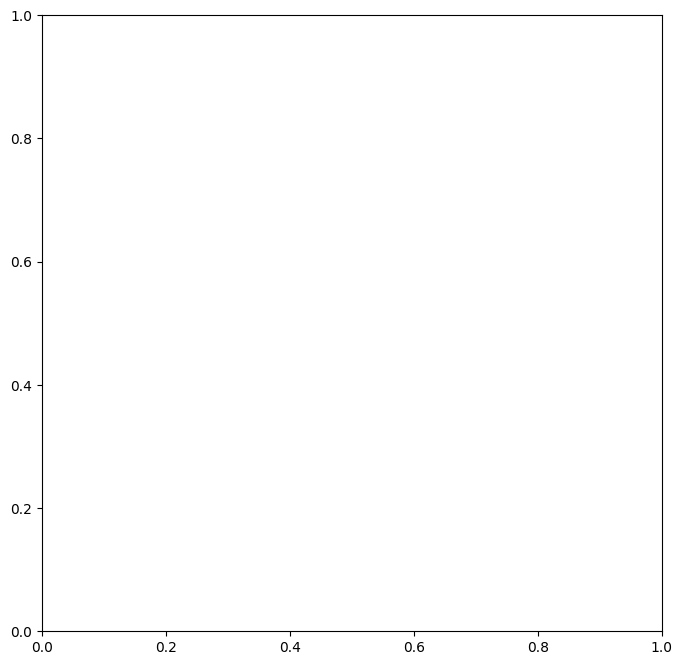

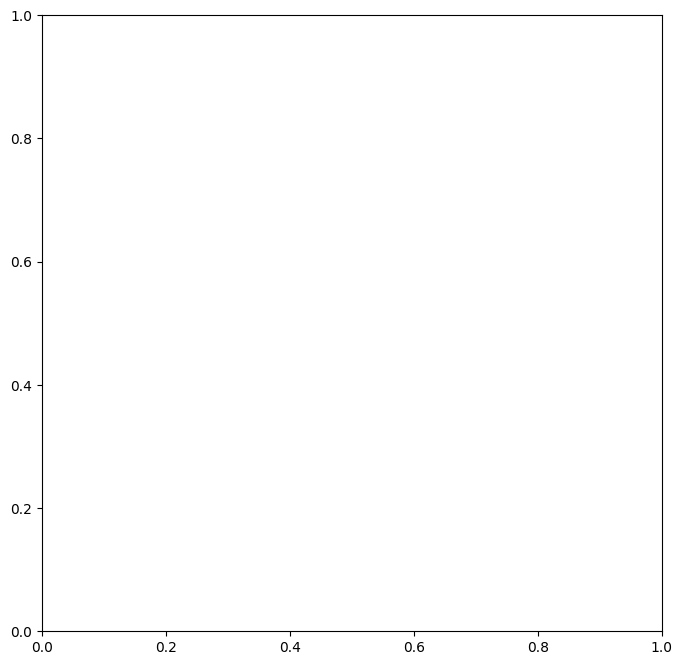

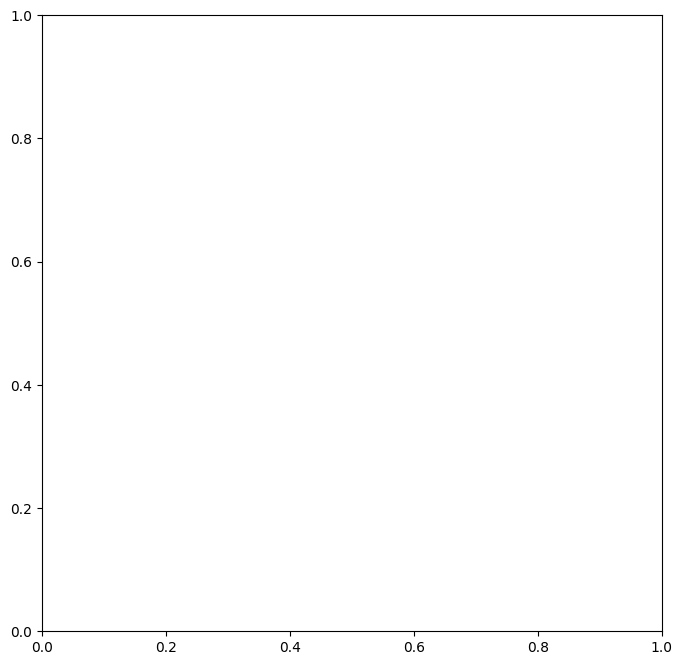

In [91]:
grouped = df.groupby('Operation').agg({
        'Host Time': "sum",
        'Time Between Ops': "sum",
        'Device Time': "sum"
    })

time_columns = ['Time Between Ops', 'Device Time', 'Host Time']
for col in time_columns:
    sorted_times = grouped[col]
    print(col, sorted_times)
    top_times    = sorted_times


    labels = top_times.index.tolist()
    sizes  = top_times.values
    print(sizes)
    pct    = 100 * sizes / sizes.sum()
    fig, ax = plt.subplots(figsize=(8, 8))
    # wedges, _ = ax.pie(sizes, startangle=140)   # no autopct ⇒ nothing on pie
  

In [93]:
df.groupby('Operation').agg({
        'Host Time': "mean",
        'Time Between Ops': "mean",
        'Device Time': "mean"
    })

,Host Time,Time Between Ops,Device Time
Operation,,,
BinaryNgDeviceOperation,2547.3,32397.433333,3.306969e+06
MorehLayerNormBackwardGammaBetaGradOperation,2843.0,582.400000,4.048321e+07
MorehLayerNormBackwardInputGradOperation,5318.0,89160.300000,1.930298e+07
MorehLayerNormOperation,3772.9,73163.800000,1.318784e+07


In [ ]:
df.sum(axis=1).values


TypeError: can only concatenate str (not "int") to str

In [88]:
grouped

,Host Time,Time Between Ops,Device Time
Operation,,,
BinaryNgDeviceOperation,76419,971923,99209080
MorehLayerNormBackwardGammaBetaGradOperation,28430,5824,404832053
MorehLayerNormBackwardInputGradOperation,53180,891603,193029820
MorehLayerNormOperation,37729,731638,131878421


In [97]:
def draw_diagrams_with_aggregation(aggregation):
    grouped = df.groupby('Operation').agg({
        'Host Time': aggregation,
        'Time Between Ops': aggregation,
        'Device Time': aggregation
    })
    topk = 15
    time_columns=['Host Time', 'Time Between Ops','Device Time']
    for col in time_columns:
        # ----- top-k + “Others” slice -------------------------------------
        sorted_times = grouped[col]
        top_times    = sorted_times.head(topk)
        others_sum   = sorted_times.iloc[topk:].sum()
        if others_sum:
            top_times = pd.concat([top_times, pd.Series({'Others': others_sum})])

        labels = top_times.index.tolist()
        sizes  = top_times.values
        pct    = 100 * sizes / sizes.sum()

        # ----- plot -------------------------------------------------------
        fig, ax = plt.subplots(figsize=(8, 8))
        wedges, _ = ax.pie(sizes, startangle=140)   # no autopct ⇒ nothing on pie

        legend_text = [f'{lbl} — {p:.1f}%' for lbl, p in zip(labels, pct)]
        ax.legend(
            wedges,
            legend_text,
            title=f'Operations (share of {aggregation})',
            loc='center left',
            bbox_to_anchor=(1, 0.5)
        )

        ax.set_title(f'Top {topk} Operations by {aggregation} {col}')
        ax.axis('equal')
        plt.show()

    top_times = grouped.sum(axis=1)
    labels = top_times.index.tolist()
    sizes  = top_times.values
    pct    = 100 * sizes / sizes.sum()

    # ----- plot -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, _ = ax.pie(sizes, startangle=140)   # no autopct ⇒ nothing on pie

    legend_text = [f'{lbl} — {p:.1f}%' for lbl, p in zip(labels, pct)]
    ax.legend(
        wedges,
        legend_text,
        title=f'Overall',
        loc='center left',
        bbox_to_anchor=(1, 0.5)
    )
    ax.set_title(f'Overall')
    ax.axis('equal')
    plt.show()

        # display(fig)    # ➋ show it once

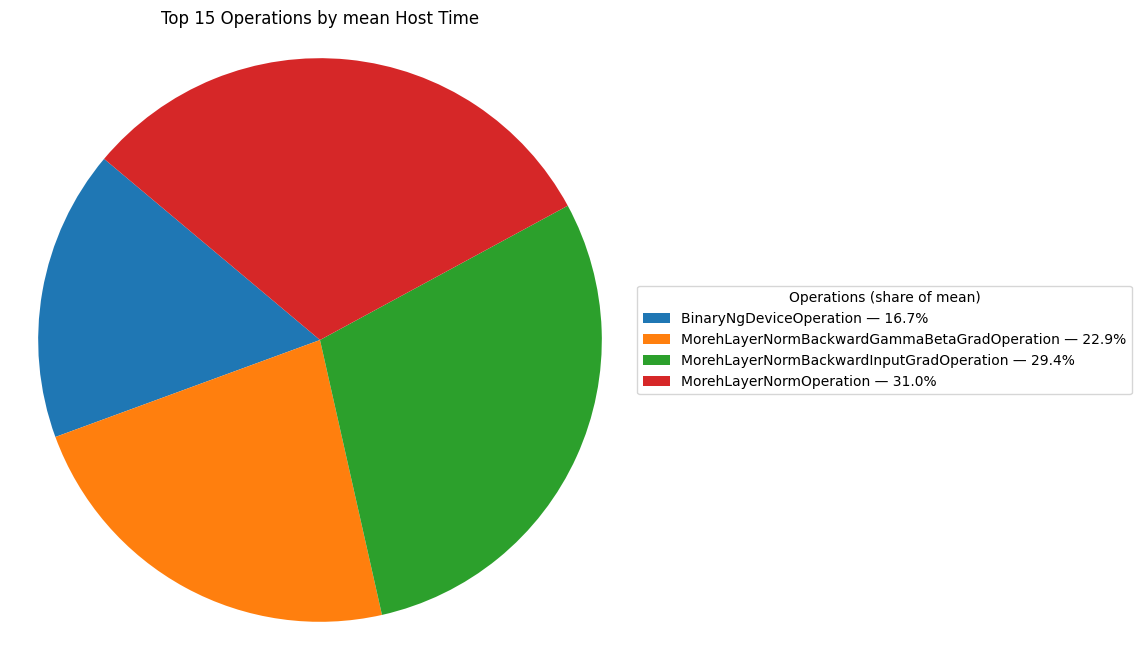

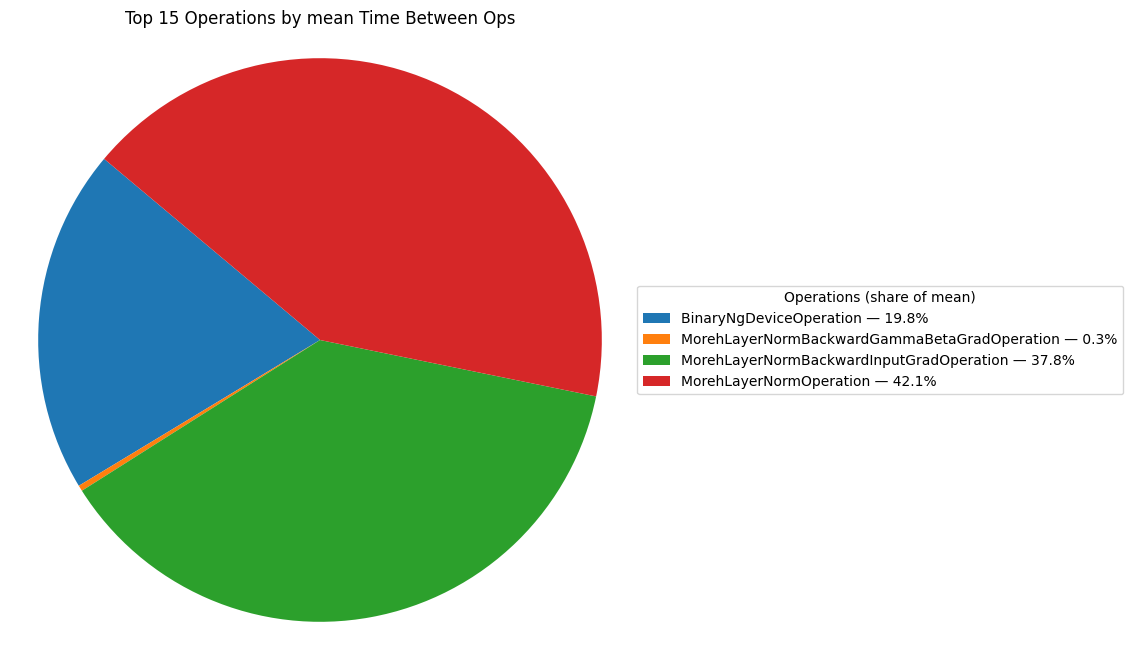

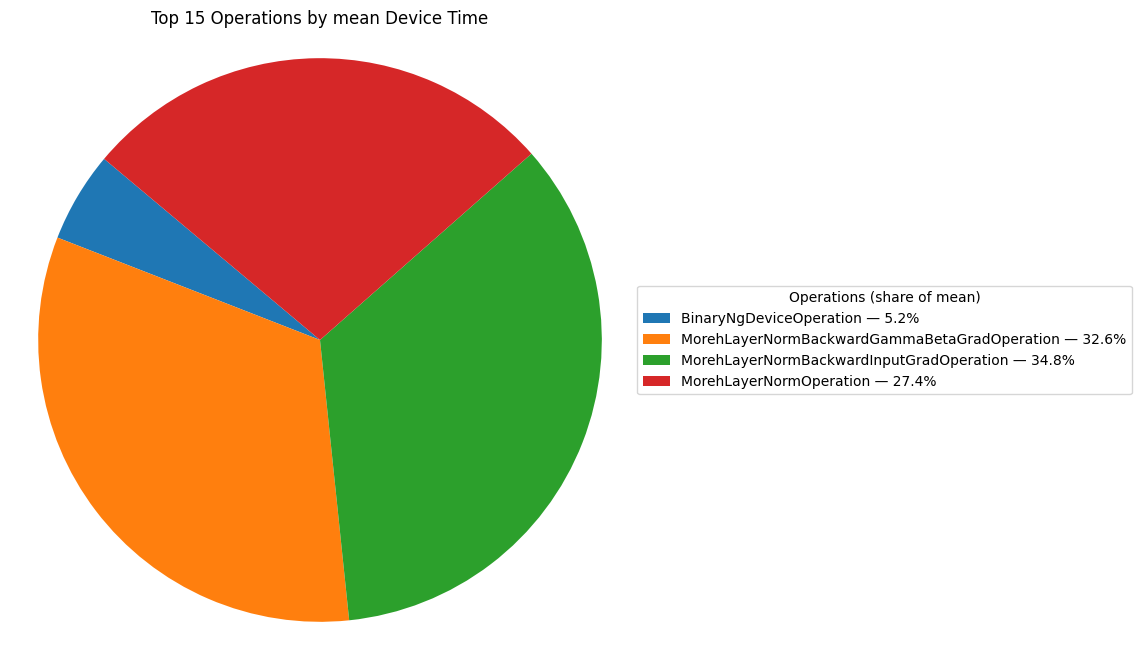

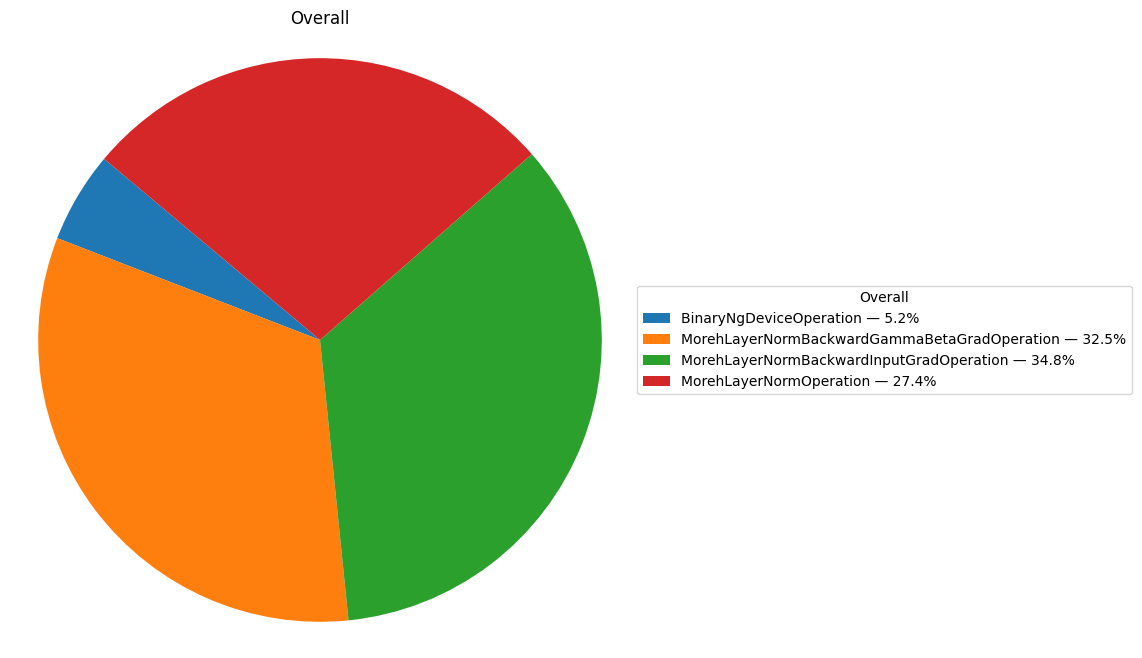

In [98]:
draw_diagrams_with_aggregation('mean')

In [ ]:
draw_diagrams_with_aggregation('mean')

ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 800x800 with 1 Axes>

In [ ]:
def name_per_aggregation(aggregation):
    if aggregation == 'sum':
        return 'Total (per training step)'
    elif aggregation == 'mean':
        return 'Average'
    else:
        raise ValueError(f"Unsupported aggregation: {aggregation}")
    
def draw_charts_with_aggregation(aggregation):
    grouped = df.groupby('Operation').agg({
        'Host Time': aggregation,
        'Time Between Ops': aggregation,
        'Device Time': aggregation
    })

    time_columns = ['Time Between Ops', 'Device Time', 'Host Time']

    # Loop through each time column to create horizontal bar charts and pie charts
    for col in time_columns:
        # Extract the total times per operation for the current column
        total_times = grouped[col] / 1_000_000  # Convert from nanoseconds to milliseconds
        if aggregation == 'sum':
            total_times /= num_training_steps  # Normalize by number of training steps if aggregation is 'sum'
        
        # Create a horizontal bar chart
        plt.figure(figsize=(10, 6))
        total_times.sort_values().plot(kind='barh', color='skyblue') 
        plt.title(f'{name_per_aggregation(aggregation)} {col} per Operation')
        plt.xlabel(f'{name_per_aggregation(aggregation)} {col} (ms)')
        plt.ylabel('Operation')
        plt.tight_layout()
        plt.show()

In [ ]:
sum([0.0961914 0.269531 -0.326172 0.550781 0.144531 -0.105957 -0.0206299 -0.0253906 0.24707 0.217773 -0.226562 0.212891 -0.15625 -0.0727539 -0.157227 0.201172 0.173828 0.118164 0.081543 0.130859 0.155273 -0.108887 -0.188477 -0.349609 0.0302734 -0.197266 0.123535 -0.300781 0.345703 -0.0600586 0.197266 -0.333984])

In [ ]:
draw_charts_with_aggregation('mean')

In [ ]:
draw_charts_with_aggregation('sum')

In [ ]:
@interact(operation=all_operations)
def draw_per_operation_stats(operation):
    df_op = df[df['Operation'] == operation]
    if df_op.empty:
        print(f"No data available for operation: {operation}")
        return

    metrics = [
        ('Host Time (ms)',          df_op['Host Time']        / 1_000_000),
        ('Time Between Ops (ms)',   df_op['Time Between Ops'] / 1_000_000),
        ('Device Time (ms)',        df_op['Device Time']      / 1_000_000),
    ]

    for title, series in metrics:
        # --- build figure explicitly so we know which one to close ------------
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(series.index, series.values, marker='o', color='red')
        ax.set_title(f'{operation} – {title}')
        ax.set_xlabel('Index')
        ax.set_ylabel(title)
        ax.grid(True)
        fig.tight_layout()
        plt.show()

In [ ]:
# example how to manually extract performance data for a specific operation
e = df[df['Operation'] == 'Untilize']
e = e[['Operation', 'Host Time', 'Time Between Ops', 'Device Time']]
e

In [ ]:
metrics = ['Host Time', 'Time Between Ops', 'Device Time']

def anomaly_detection_per_operation(operation, metric):
    df_op = df[df['Operation'] == operation]
    if df_op.empty:
        print(f"No data available for operation: {operation}")
        return

    # Calculate the mean and standard deviation for each metric
    
    series = df_op[metric]
    
    mean = series.mean()
    std_dev = series.std()
    
    # Identify anomalies as points that are more than 3 standard deviations from the mean
    anomalies = series[(series < mean - 3 * std_dev) | (series > mean + 3 * std_dev)]
    
    if not anomalies.empty:
        return df_op.loc[anomalies.index]
    return None

In [ ]:
import json

def is_not_nan(value):
    """Check if a value is not NaN."""
    return pd.notna(value) and value != 'NaN' and value != 'nan' and value != ''

@interact(operation=all_operations, metric_name=metrics)
def show_anomalies_attributes_per_metric(operation, metric_name):
    anomaly_df = anomaly_detection_per_operation(operation, metric_name)

    if anomaly_df is None:
        print(f"No anomalies detected for {operation} in {metric_name}.")
        return

    for index, row in anomaly_df.iterrows():
        attr = row['ATTRIBUTES']
        core_count = row['CORE COUNT']
        metric_value = row[metric_name]

        # find all columns with prefix `INPUT_`
        input_columns = [col for col in row.index if col.startswith('INPUT_')]
        input_values = {col: row[col] for col in input_columns if is_not_nan(row[col])}

        # improve print of dictionary with json
        input_values = json.dumps(input_values, indent=8)

        if isinstance(attr, str):
            attr = attr.replace(';', ',')
            attr = attr.replace('\'', '"')
            try:
                attr = json.loads(attr)
            except:
                pass
            attr = json.dumps(attr, indent=8) if isinstance(attr, dict) else attr

        print(f"Anomaly at index {index}: ")
        print(f"    {metric_name} = {metric_value / 1_000_000} ms")
        print(f"    core count = {core_count}")
        print(f"    inputs = {input_values}")
        print(f"    attributes = {attr}")


In [ ]:
# Extract specific LayerNorm operations data
layernorm_ops = [
    'MorehLayerNormBackwardGammaBetaGradOperation', 
    'MorehLayerNormBackwardInputGradOperation', 
    'MorehLayerNormOperation'
]

# Get the grouped data for these specific operations
layernorm_data = grouped.loc[layernorm_ops]
print("LayerNorm Operations Performance Data:")
print("="*60)
print(layernorm_data)

# Also show with better formatting
print("\n" + "="*60)
print("Formatted View (in milliseconds per training step):")
print("="*60)
for op in layernorm_ops:
    if op in grouped.index:
        row = grouped.loc[op]
        print(f"\n{op}:")
        print(f"  Host Time:        {row['Host Time']/1_000_000/num_training_steps:.3f} ms/step")
        print(f"  Time Between Ops: {row['Time Between Ops']/1_000_000/num_training_steps:.3f} ms/step") 
        print(f"  Device Time:      {row['Device Time']/1_000_000/num_training_steps:.3f} ms/step")
    else:
        print(f"\n{op}: NOT FOUND in data")
